In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Reading the Data

In the following section the variables that are used have to be filled in. The possible variables that can be used are found in the `weathermerge.ipynb` file.

In [2]:
target = 'plh0182'

# all the time invariant variables
timeinvariant = {
    "sex", "bula_h", 'age', 'year', 'month'
}

# all the time variant variables
timevariant = {
    # soep covariates
    'partner', # partner
    'plb0021', # unemployed
    'plh0171', # satisfaction with health
    'plh0175', # satisfaction with hh income
    'plh0182', # satisfaction with life
    'hlc0043', # number of children
    'e11103', # labour participation
    'hlf0001_h', # home ownership
    'hlc0005_h', # monthly hh income
    #'hlk0056', # type of interview
    
    # weather main vars
    'tavgbin_0_Msum', 'tavgbin_1_Msum', 'tavgbin_2_Msum', 
    'tavgbin_3_Msum', 'tavgbin_4_Msum', 'tavgbin_5_Msum', 'tavgbin_6_Msum', 'tavgbin_7_Msum',
    # weather control
    'prcp_Mmean', 'tsun_Mmean',
    'wspd_Mmean', 'pres_Mmean', 'snow_Mmean'#, 'tavg_Mstd', 'tavg_Mmean'
}

categorical = {
    'bula_h', 'sex', 'year', 'month',
    'plb0021', # unemployed
    'partner',
    'e11103', # labour participation
    'hlf0001_h', # home ownership
    #'hlk0056', # type of interview
}

# all the time variant variables that we want to calculcate the difference for
derivs = {
    'plh0171', # satisfaction with health
    'plh0175', # satisfaction with hh income
    'plh0182', # satisfaction with life
}

# all columns are the union of our variable sets. "pid" and "year" need to be added as indecies
columns = timeinvariant.union(timevariant).union({'pid', 'year'})

In [3]:
# check that all the variables are correctly defined
assert all(map(lambda x: x in columns, categorical)), "Some categorical variables are not in timevariant/timeinvariant"
assert all(map(lambda x: x in columns, derivs)), "Some derivs variables are not in timevariant/timeinvariant"

In [4]:
# read data frame
soep = pd.read_parquet('./prod/data.parquet.snappy', columns=list(columns))
soep

,tavgbin_2_Msum,e11103,pres_Mmean,bula_h,tavgbin_1_Msum,month,sex,partner,wspd_Mmean,tavgbin_0_Msum,...,plh0182,plh0175,tavgbin_7_Msum,hlc0005_h,plb0021,hlc0043,snow_Mmean,year,prcp_Mmean,plh0171
0,1.0,1.0,1022.710889,1.0,10.0,3,1.0,1.0,16.067679,19.0,...,7.0,8.0,0.0,1473.0,2.0,NaN,6.516484,1985,0.489066,7.0
1,1.0,2.0,1022.710889,1.0,10.0,3,2.0,1.0,16.067679,19.0,...,6.0,8.0,0.0,1473.0,2.0,NaN,6.516484,1985,0.489066,3.0
2,1.0,1.0,1022.710889,1.0,10.0,3,1.0,2.0,16.067679,19.0,...,7.0,7.0,0.0,1298.0,2.0,NaN,6.516484,1985,0.489066,8.0
3,1.0,1.0,1022.710889,1.0,10.0,3,2.0,2.0,16.067679,19.0,...,7.0,7.0,0.0,1298.0,2.0,NaN,6.516484,1985,0.489066,9.0
4,0.0,3.0,1023.257556,1.0,11.0,3,1.0,2.0,14.883333,19.0,...,8.0,5.0,0.0,1432.0,1.0,NaN,6.516484,1985,0.538590,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
722375,4.0,3.0,1016.004634,16.0,21.0,12,1.0,1.0,12.314889,5.0,...,7.0,NaN,0.0,1500.0,1.0,3.0,3.547619,2020,0.483390,4.0
722376,4.0,1.0,1016.154158,16.0,21.0,12,1.0,0.0,11.976222,5.0,...,6.0,NaN,0.0,1300.0,2.0,0.0,3.547619,2020,0.397627,10.0
722377,4.0,2.0,1016.154158,16.0,21.0,12,2.0,0.0,11.976222,5.0,...,6.0,NaN,0.0,750.0,1.0,2.0,3.547619,2020,0.397627,8.0
722378,3.0,3.0,1016.039396,16.0,22.0,12,1.0,1.0,11.884667,5.0,...,10.0,NaN,0.0,2500.0,2.0,6.0,3.547619,2020,0.379096,5.0


# Data Preparation

In the following the data is brought into the right format for the Decision Tree Regressor. This includes the steps:
1. First the frequency of values for the categorical variables is checked. Some variables have very infrequent values that should be removed.
2. Partition data into timevariant and timeinvariant variables. The timevariant data is process as follows:
    1. For each subject fill in missing survey years.
    2. Forward fill nan values (only when two consecutive survey years are missing).
    3. Remove remaining nan values.
    4. Create a window of specified size (`window_size`) to create time series like data that is readable for a tree regressor. This id done by concatonating future time steps with current time steps.
3. This window is merged back with the time invariant data. A timeinvariant variable is for instance `sex`.
4. Changing categorical values into dummies.

## Outlier Checking

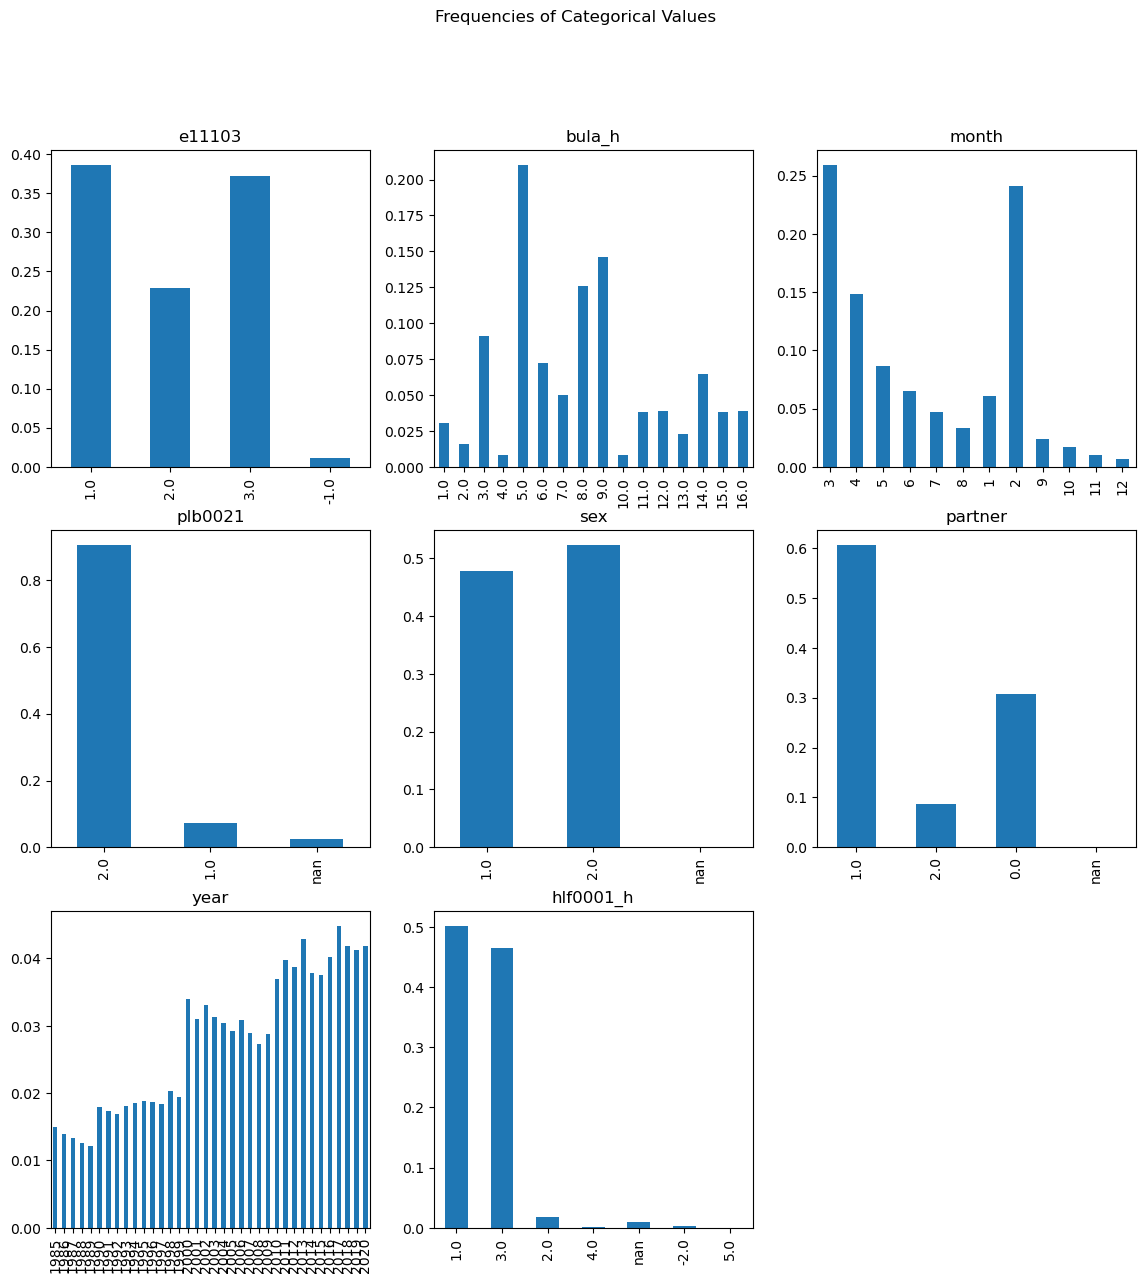

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure(figsize=(14,14))
fig.suptitle("Frequencies of Categorical Values")
for i, var in enumerate(categorical):
    ax = fig.add_subplot(1 + (len(categorical) // 3), 3, i+1)
    soep[var].value_counts(normalize=True, sort=False, dropna=False).plot(kind='bar', ax=ax)
    ax.set_title(var)

## Creating the Window

In [6]:
         
def create_window(df, timevariant, window):
    # here onle timevariant data is treatet
    # it is assumed that all the data was already preprocessed
    df = df[list(timevariant.union({'pid', 'year'}))]
    
    print("Filling in gap years...")
    # we need to fill in gap years in observations
    minyear, maxyear = min(df['year']), max(df['year'])        
    new_index = pd.MultiIndex.from_product(
        [df['pid'].unique(), np.arange(minyear, maxyear+1)],
        names=['pid', 'year']
    )
    
    # set the new index. Gap years are filled with nan values
    df = df.set_index(['pid','year']).sort_index()
    df = df.reindex(new_index)
    
    # interpolate TODO: check if this is ok
    print("Interpolating nan values...")
    df = df.interpolate(method='linear', limit=2, limit_area='inside')\
           .dropna()
    
    # get all possible rows -> saves memory and computations
    print("Filter windows that have to view observations...")
    df = df.reset_index()\
           .sort_values(['pid', 'year'])\
           .reset_index(drop=True)
    df = df.groupby(
                 ((df['year'].shift(-1) != df['year']+1) |
                  (df['pid'].shift() != df['pid'])).cumsum())\
           .filter(lambda x: x.shape[0] >= window)\
           .set_index(['pid', 'year'])
    
    # create the first timestamp is created (just a ref to df)
    df = df.add_suffix('_0')
    t0_cols = list(map(lambda x: x+"_0", timevariant))
    
    # create window
    print("Creating Windows...")
    for i in tqdm(range(1, window)):
        # shift year
        ti = df.loc[:, t0_cols].groupby('pid').shift(-i)
        # set new column names
        ti.columns = list(map(lambda x: x[:-1]+str(i), ti.columns))
        # join with df
        df = df.join(ti, how='left')
        # Drop rows with gaps
        df.dropna(inplace=True)
    return df

# set how large the window should be
window_size = 7

# create window
data = create_window(soep, timevariant, window_size)

Filling in gap years...
Interpolating nan values
Filter windows that have to view observations
Creating Windows


100%|█████████████████████████████████████████████| 6/6 [00:01<00:00,  4.89it/s]


In [7]:
# calculate derivatives
def deriv(var, window, data):
    for v in var:
        for t in range(window_size-1, 0, -1):
            data.loc[:, f'{v}_{t}'] = data[f'{v}_{t-1}'] - data[f'{v}_{t}']
        data.drop(columns=f'{v}_0', inplace=True)
    return data

data = deriv(derivs, window_size, data)

## Joining Timeinvariant Data

In [8]:
# merge with time invariant data
timeinv = soep[list(timeinvariant.union({'pid', 'year'}))].set_index(['pid', 'year'])
data = data.join(timeinv, how='left')\
           .dropna()\
           .reset_index()

# free memory
del soep

data

,pid,year,tavgbin_2_Msum_0,e11103_0,pres_Mmean_0,tavgbin_1_Msum_0,partner_0,wspd_Mmean_0,tavgbin_0_Msum_0,tsun_Mmean_0,...,hlc0005_h_6,plb0021_6,hlc0043_6,snow_Mmean_6,prcp_Mmean_6,plh0171_6,bula_h,age,month,sex
0,901,1995,13.0,1.0,1009.149444,17.0,0.0,21.849167,0.0,232.600000,...,1176.0,2.0,0.0,21.600000,1.738889,0.0,11.0,44.0,3.0,2.0
1,901,1996,0.0,1.0,1019.007500,16.0,0.0,16.353333,14.0,248.350000,...,1100.0,2.0,0.0,2.133333,2.347222,3.0,11.0,45.0,3.0,2.0
2,901,1997,7.0,1.0,1022.987500,16.0,0.0,20.547500,7.0,150.150000,...,1100.0,2.0,0.0,0.533333,0.563333,0.0,11.0,46.0,2.0,2.0
3,901,1998,18.0,2.0,1016.845556,6.0,0.0,22.571389,0.0,129.800000,...,1100.0,2.0,0.0,0.000000,1.164667,-3.0,11.0,47.0,3.0,2.0
4,1501,1995,14.0,1.0,1014.514328,13.0,0.0,18.379171,3.0,135.907692,...,2471.0,2.0,0.0,12.843447,2.299315,0.0,8.0,37.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13100,7250902,1998,14.0,3.0,1025.271693,9.0,1.0,12.575635,6.0,229.960000,...,3062.0,2.0,3.0,16.614035,3.081738,-1.0,7.0,20.0,3.0,2.0
13101,7255202,1997,14.0,2.0,1015.403269,8.0,1.0,13.379179,0.0,404.940308,...,2350.0,2.0,2.0,5.790459,1.011682,0.0,8.0,21.0,5.0,2.0
13102,7255202,1998,17.0,2.0,1024.421509,8.0,1.0,15.290024,2.0,231.038095,...,2400.0,2.0,2.0,36.482927,1.199273,0.0,8.0,22.0,3.0,2.0
13103,7256202,1998,13.0,1.0,1026.662990,11.0,1.0,12.233958,5.0,248.926196,...,1900.0,2.0,1.0,144.527200,4.239245,-1.0,9.0,20.0,3.0,2.0


## Create Dummies and Normalization

Here the `OneHotEncoder` from `sklearn` is used. This is more memory efficient than the pandas `get_dummies` function. However, the encoder by default encodes all variables of the dataset. Therefore, a `ColumnTransformer` is needed that splits categorical variables from the others. The non-categorical variables are not further processed. It would be possible to run a normalizer on the data. Regression models, however, do not require normalized data. 

An idea would be to first run a PCA to get fever variables. This would make the computation less expensive. Should this be the case the data needs to be normalized.

In [9]:
# create x and y datasets
ypd = data[f'{target}_{window_size - 1}'] # last observation
Xpd = data[[x for x in data.columns if x != f'{target}_{window_size - 1}']]

In [10]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer

# create the one hot encoder
ohe = OneHotEncoder(
    handle_unknown='ignore'
)

# create the normalizer
sc = StandardScaler()

# create a dummy processor -> just forwards data
ft = FunctionTransformer()

# create categories for all of the columns
cats = []
for cat in categorical:
    # for each timevariant categorical variable suffixes need to be added
    if cat in timevariant:
        for i in range(0, window_size):
            cats.append(cat + f'_{i}')
    else:
        cats.append(cat)
non_cats = [x for x in list(Xpd.columns) if x not in cats]
        
# split the columns into categorical and numerical
ct = ColumnTransformer(
    transformers = [
        ('categorical', ohe, cats),
        ('non-categorical', sc, non_cats)
    ]
)

In the following the PCA object is created. 

In [11]:
from sklearn.decomposition import PCA

# we take all the PC such that 95% of the data is explained
pca = PCA(n_components=0.98)

# Training

Training the model includes the following steps:

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xpd, ypd, test_size=0.33)

## Baseline Model

The following model simply takes over the target variable of the last timestep before the prediction.

In [20]:
from sklearn.metrics import mean_absolute_error


y_pred = np.repeat(0, y_test.shape) # no change in swb
y_true = y_test
mean_absolute_error(y_true, y_pred)

0.9674450867052025

## Hyper Parameter Fitting

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

"""
hp = {
    'max_depth' : range(1, 200),
    'min_samples_split' : range(1, 100),
    'min_samples_leaf' : list(range(1, 100))
}

rfs = RandomForestRegressor(n_estimators=100, n_jobs=-1)
gs = RandomizedSearchCV(rfs, hp, n_iter=500, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)


pl = Pipeline(steps=[('preprocessing', ct), ('grid search', gs)])
pl.fit(X_train, y_train)

rfs = gs.best_estimator_
performance = pd.DataFrame(gs.cv_results_)
"""

"\nhp = {\n    'max_depth' : range(1, 200),\n    'min_samples_split' : range(1, 100),\n    'min_samples_leaf' : list(range(1, 100))\n}\n\nrfs = RandomForestRegressor(n_estimators=100, n_jobs=-1)\ngs = RandomizedSearchCV(rfs, hp, n_iter=500, n_jobs=-1, scoring='neg_mean_squared_error', cv=5)\n\n\npl = Pipeline(steps=[('preprocessing', ct), ('grid search', gs)])\npl.fit(X_train, y_train)\n\nrfs = gs.best_estimator_\nperformance = pd.DataFrame(gs.cv_results_)\n"

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

rfs = RandomForestRegressor(
    n_estimators=1000, n_jobs=4,
    max_features='sqrt',
    max_depth=700,
    min_samples_split=5,
    min_samples_leaf=5
)
#{'min_samples_split': 1, 'min_samples_leaf': 50, 'max_depth': 14}

lm = LinearRegression(n_jobs=4)

In [16]:
from sklearn.pipeline import Pipeline

pl = Pipeline(
    steps=[
        ('preprocessing', ct), 
        #('PC decomposition', pca), 
        ('regressor', rfs)])
pl.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['e11103_0', 'e11103_1',
                                                   'e11103_2', 'e11103_3',
                                                   'e11103_4', 'e11103_5',
                                                   'e11103_6', 'bula_h',
                                                   'month', 'plb0021_0',
                                                   'plb0021_1', 'plb0021_2',
                                                   'plb0021_3', 'plb0021_4',
                                                   'plb0021_5', 'plb0021_6',
                                                   'sex', 'partner_0',
                                                   'partner_1', 'partner_2',
                                                   'partner_3...
                                                   'pres_Mmean_1',
                                                   'tavgbin_1_Msum_1',
                                                   'wspd_Mmean_1',
                                                   'tavgbin_0_Msum_1',
                                                   'tsun_Mmean_1',
                                                   'tavgbin_4_Msum_1',
                                                   'tavgbin_3_Msum_1',
                                                   'tavgbin_6_Msum_1',
                                                   'tavgbin_5_Msum_1',
                                                   'plh0182_1', 'plh0175_1',
                                                   'tavgbin_7_Msum_1',
                                                   'hlc0005_h_1', ...])])),
                ('regressor',
                 RandomForestRegressor(max_depth=700, max_features='sqrt',
                                       min_samples_leaf=5, min_samples_split=5,
                                       n_estimators=1000, n_jobs=4))])

In [17]:
from sklearn.metrics import mean_absolute_error
y_pred = pl.predict(X_test)
mean_absolute_error(y_test, y_pred)

0.9266952833941307